<a href="https://colab.research.google.com/github/ayrna/ap2122/blob/main/redes_recurrentes/time_series_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Keras to Build and Train Recurrent Neural Networks

In this task, you will be developing a LSTM network using the Keras to solve a time-series prediction problem.

As the name suggests, time-series is a collection of data points collected at constant time intervals. These are analysed to determine the long term trend so as to forecast the future or perform some other form of analysis. 

The problem we are going to look at in this task is the International Airline Passengers prediction problem. For this problem we are given a year and a month we need to predict the number of international airline passengers in units of 1,000. In other words we need to answer the question, "Given the number of passengers (in units of thousands) this month, what is the number of passengers next month?". 

The data ranges from January 1949 to December 1960 with 144 observations.

You are provided with the incomplete code below. You are required to complete the code in order for it to run correctly. 


---

We first need to import all of the functions and classes we intend to use. We need to import NumPy for scientific computation, Matplotlib for plotting graphs, and Pandas to aide in loading and manipulating our datasets.

In [7]:
import tensorflow as tf
from tensorflow import keras

import numpy
import matplotlib.pyplot as plt
import pandas as pd
import math

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

The next step is to load in our training dataset as a Pandas dataframe. We can then extract the NumPy array from the dataframe and convert the integer values to floating point values, which are more suitable for modeling with a neural network.

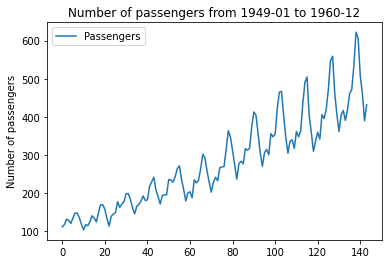

In [8]:
# load the dataset using Pandas (remember to find and download the international airlines passengers dataset)
df = pd.read_csv("airline-passengers.csv")

# extract the NumPy array from the dataframe
Numpy_arr = numpy.array(df['Passengers'].tolist())

# convert the integer values to floating point values
Numpy_arr = Numpy_arr.astype(float)

# Use matplotlib to plot the whole dataset 
df.plot()
plt.title("Number of passengers from 1949-01 to 1960-12")
plt.ylabel("Number of passengers")
plt.show()

In [9]:
Numpy_arr

array([112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
       118., 115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
       114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
       162., 146., 166., 171., 180., 193., 181., 183., 218., 230., 242.,
       209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264.,
       272., 237., 211., 180., 201., 204., 188., 235., 227., 234., 264.,
       302., 293., 259., 229., 203., 229., 242., 233., 267., 269., 270.,
       315., 364., 347., 312., 274., 237., 278., 284., 277., 317., 313.,
       318., 374., 413., 405., 355., 306., 271., 306., 315., 301., 356.,
       348., 355., 422., 465., 467., 404., 347., 305., 336., 340., 318.,
       362., 348., 363., 435., 491., 505., 404., 359., 310., 337., 360.,
       342., 406., 396., 420., 472., 548., 559., 463., 407., 362., 405.,
       417., 391., 419., 461., 472., 535., 622., 606., 508., 461., 390.,
       432.])

LSTMs are sensitive to the scale of the input data. It can be a good practice to rescale the data to the range of 0-to-1, also called normalising. In our case, we’ll use Scikit- Learn’s MinMaxScaler and scale our dataset to numbers between zero and one.

In [10]:
Numpy_arr = Numpy_arr.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(Numpy_arr)

After we model our data and estimate the skill of our model on the training dataset, we need to get an idea of the skill of the model on new unseen data. With time series data, the sequence of values is important. A simple method that we can use is to split the ordered dataset into train and test datasets. The code below calculates the index of the split point and separates the data into the training datasets with 67% of the observations that we can use to train our model, leaving the remaining 33% for testing the model.

In [11]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

Now we can define a function to create a new dataset, as described above.

The function takes two arguments: the dataset, which is a NumPy array that we want to convert into a dataset, and the look_back, which is the number of previous time steps to use as input variables to predict the next time period — in this case defaulted to 1.

This default will create a dataset where X is the number of passengers at a given time (t) and Y is the number of passengers at the next time (t + 1).


In [12]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

We can now use this function to prepare the train and test datasets for modeling.

In [13]:
look_back = 1
# use the create_dataset() function to prepare the train dataset
trainX, trainY = create_dataset(train, look_back)

# use the create_dataset() function to prepare the test dataset
testX, testY = create_dataset(test, look_back)

The LSTM network expects the input data (X) to be provided with a specific array structure in the form of: [samples, time steps, features].

Currently, our data is in the form: [samples, features] and we are framing the problem as one time step for each sample. We can transform the prepared train and test input data into the expected structure using numpy.reshape().

In [14]:
# reshape the trian input (trainX) to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))

# reshape the test input (testX) to be [samples, time steps, features]
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

We are now ready to design our LSTM network for this problem.

The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The sigmoid activation function is used for the LSTM blocks. 

In [15]:
# create a sequential model
model = Sequential()

#create a LSTM layer
model.add(LSTM(4, input_shape=(1, look_back)))

# create a Dense layer
model.add(Dense(1))

Next complile and fit the model. The network is trained for 100 epochs and a batch size of 1 is used.

In [19]:
# Compile the model
model.compile(optimizer="adam", loss='mean_squared_error')

# Fit the model
model.fit(trainX, trainY, epochs=100, batch_size=1)

Epoch 1/100
94/94 [==============================] - 2s 2ms/step - loss: 0.0020
Epoch 2/100
94/94 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 3/100
94/94 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 4/100
94/94 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 5/100
94/94 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 6/100
94/94 [==============================] - 0s 3ms/step - loss: 0.0019
Epoch 7/100
94/94 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 8/100
94/94 [==============================] - 0s 3ms/step - loss: 0.0020A: 0s - loss: 0.
Epoch 9/100
94/94 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 10/100
94/94 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 11/100
94/94 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 12/100
94/94 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 13/100
94/94 [=

Once the model is fit, we can estimate the performance of the model on the train and test datasets. This will give us a point of comparison for new models.

Note that we invert the predictions before calculating error scores to ensure that performance is reported in the same units as the original data (thousands of passengers per month).

In [21]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 22.62 RMSE
Test Score: 55.27 RMSE


Finally, we can generate predictions using the model for both the train and test dataset to get a visual indication of the skill of the model.

Because of how the dataset was prepared, we must shift the predictions so that they align on the x-axis with the original dataset. Once prepared, the data is plotted, showing the original dataset in blue, the predictions for the training dataset in green, and the predictions on the unseen test dataset in red.

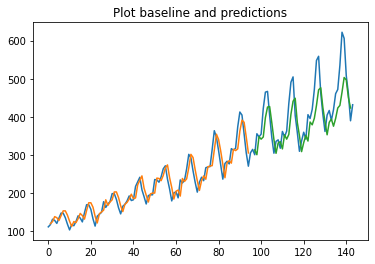

In [22]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# Complete: Plot baseline and predictions
plt.title("Plot baseline and predictions")
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()



We can see that the model did an excellent job of fitting both the training and the test datasets.